# N3OX Parasitic 20m 11-circle

Following on antenna optimizations using [`PyNEC`](https://pypi.org/project/PyNEC/) with [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) to optimize a parasitic circle array. 

Inspired by [this thread on QRZ.com](https://forums.qrz.com/index.php?threads/two-theoretical-optimal-antenna-questions.717472/).

In [3]:
import platform
if not platform.node() in ['coriolis', 'axlotl']: #don't need to install on my local machines
    print(f'Platform node {platform.node()} needs package installs, please wait...')
    !pip install -q git+https://github.com/danzimmerman/n3ox_utils.git
    !pip install -q PyNEC==1.7.3.4
    print('... installation complete.')

import numpy as np
import matplotlib.pyplot as plt
import string
import pyswarm

plt.rcParams.update({'font.size':20})
plot_colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]
tables = {}
figs = {}

class plot_tools:
    """
    Simple box-of-functions class to collect plot manipulation methods.
    """
    def __init__(self):
        pass
    
    def gridfig(self, nrows, ncols, rowheight=4, width=15):
        fig = plt.figure(figsize=(width, nrows*rowheight), facecolor='w')
        axs = fig.subplots(nrows, ncols)
        for ax, l in zip(axs.flatten(), string.ascii_lowercase):
            setattr(fig, f'ax{l}', ax)
        return fig

    def label_axes(self, fig, x=0.925, y=0.85):
        for ax, l in zip(fig.axes, string.ascii_lowercase):
            ax.annotate(l, xy=(x, y), xytext=(x, y), 
                        xycoords='axes fraction',
                    fontstyle='italic',
                    bbox={'facecolor':'w', 'alpha':0.5, 'boxstyle':'round'})
            
pt = plot_tools()

import n3ox_utils.pynec_helpers as pnh
import n3ox_utils.plot_tools as ptl
import PyNEC as pynec
from scipy.constants import speed_of_light as cee

from IPython.display import clear_output

import scipy.optimize as scopt
plt = ptl.init_pyplot_defaults(plt)

In [4]:
help(pyswarm.pso)

Help on function pso in module pyswarm.pso:

pso(func, lb, ub, ieqcons=[], f_ieqcons=None, args=(), kwargs={}, swarmsize=100, omega=0.5, phip=0.5, phig=0.5, maxiter=100, minstep=1e-08, minfunc=1e-08, debug=False)
    Perform a particle swarm optimization (PSO)
    
    Parameters
    func : function
        The function to be minimized
    lb : array
        The lower bounds of the design variable(s)
    ub : array
        The upper bounds of the design variable(s)
    
    Optional
    ieqcons : list
        A list of functions of length n such that ieqcons[j](x,*args) >= 0.0 in 
        a successfully optimized problem (Default: [])
    f_ieqcons : function
        Returns a 1-D array in which each element must be greater or equal 
        to 0.0 in a successfully optimized problem. If f_ieqcons is specified, 
        ieqcons is ignored (Default: None)
    args : tuple
        Additional arguments passed to objective and constraint functions
        (Default: empty tuple)
    kwargs 

In [5]:
class CircleAntennaOptimizer(object):
    """
    Runs an optimization on an evenly-spaced circular array of half-wave dipoles
    to turn it into a parasitic directive array. 

    Each vertical has an odd quarter-wave feedline stub. 

    Parasitics are terminated in a reactance.
    """
    def __init__(self, frequency_MHz=14, number_of_elements=11, 
                 array_radius=10, element_height=None,
                 segments_per_element=17, wire_radius=0.0125):
        """
        frequency_MHz in MHz
        array_radius in meters
        element_height in meters

        If element_height is not specified, it's set to a free-space half wavelength

        Elements are numbered counterclockwise with #0 on the x-axis.

        Indices of driven elements (driven_tags) are 1-indexed starting at #1 on the x-axis.
        
        These are the NEC tag numbers.

        Each vertical dipole has segments_per_element segments.
        """
        self.context = None
        self.freq = float(frequency_MHz)
        self.N = int(number_of_elements)
        self.R = float(array_radius)
        self.rwire = float(wire_radius)
        if not element_height:
            self.height = cee/(self.freq*1e6)/2.0
        else:
            self.height = float(element_height)
        self.nsegs = int(segments_per_element)
            
        if not self.N==11:
            raise NotImplementedError('Optimizer target hardcoded to 11 elements for now! Sorry!')

    def gain_optimizer_target(self, optvars):
        """
        Defines the optimization target function.
        Hardcoded to five reactances for pairwise loading of 11-element array, 
        needs work for arbitrary elements.

        Optimizes on height as well
        """
        X1, X2, X3, X4, X5 = optvars
        
        self.context = pynec.nec_context()
        self.geo = self.context.get_geometry()
        self.wires = []
        ang = np.linspace(0, 2*np.pi, self.N, endpoint=False)
        x = self.R*np.cos(ang)
        y = self.R*np.sin(ang)
    
        for n, (x, y) in enumerate(zip(x, y)):
            wd = {'xw1':x, 'xw2':x, 
                  'yw1':y, 'yw2':y, 
                  'zw1':-self.height/2, 'zw2':self.height/2,
                  'rad':self.rwire, 
                  'tag_id':n+1, 'segment_count':self.nsegs,
                  'rdel':1, 'rrad':1}
            self.wires.append(wd)
       
        for wire in self.wires:
            self.geo.wire(**wire)
        self.context.geometry_complete(0)
        self.eltags = [[1], [2, 11], [3, 10], [4, 9], [5, 8], [6, 7]]
        self.elvals = [X1, X2, np.nan, X3, X4, X5]
        self.eltypes = ['L']*2 +['driven'] + ['C']*3
        for tags, loadval, eltype in zip(self.eltags, self.elvals, self.eltypes):
            if loadval<0:
                print('-')
                loadval = 0
            if eltype == 'driven':
                for tag in tags:
                    exargs = pnh.pack_ex_card_args(excitation_type='voltage',
                                                   source_tag=tag, source_seg=self.nsegs//2, #integer divide
                                                   ereal=10.0, eimag=0.0)
                    self.context.ex_card(*exargs)
            elif eltype == 'L':
                for tag in tags:
                    ldargs = pnh.pack_ld_card_args(load_type='series_RLC_lump', 
                                                   load_tag=tag,
                                                   load_seg_start=self.nsegs//2,
                                                   L=loadval, R=0, C=0)
                    self.context.ld_card(*ldargs)
            elif eltype == 'C':
                for tag in tags:
                    ldargs = pnh.pack_ld_card_args(load_type='series_RLC_lump', 
                                                   load_tag=tag,
                                                   load_seg_start=self.nsegs//2,
                                                   C=loadval, R=0, L=0)
                    self.context.ld_card(*ldargs)
            
            elif eltype == 'X':
                for tag in tags:
                    ldargs = pnh.pack_ld_card_args(load_type='load_Z',
                                                   load_tag=tag,
                                                   load_seg_start=self.nsegs//2,
                                                   R=1.0, X=loadval)
                    self.context.ld_card(*ldargs)
        
        frargs = [0, 1, self.freq, 0] #fr_card(ifrq, nfrq, freq_hz, del_freq)
        self.context.fr_card(*frargs)
        azpargs = {'calc_mode':0, 'normalization':5, 
          'n_theta':1, 'theta0':90, 'delta_theta':0,
          'n_phi':361, 'phi0':0, 'delta_phi':1, 
          'radial_distance':0, 'gain_norm':0,
          'output_format':0, 'D':0, 'A':0}
        self.context.rp_card(**azpargs)
        self.azpattern = self.context.get_radiation_pattern(0)
        self.gain = np.squeeze(self.azpattern.get_gain())
        self.azangs = self.azpattern.get_phi_angles()
        clear_output()
        mbix = (self.azangs>70) & (self.azangs<190)
        lingain = 10**(self.gain/10.0)
        retval = (lingain[~mbix].sum()/(~mbix).sum())/(lingain[mbix].sum()/mbix.sum())
        print(f'\rIterate val: {10*np.log10(retval):.2f}dB                  ')
        return retval
    
    def optimize(self, initial_guess=np.array([77e-6, 28e-12, 30e-12, 60e-12, 90e-12]),
                 param_bounds=scopt.Bounds([0]*6, [2e-6]*2+[1e-9]*3)):
        """
        Runs the optimization
        """
        self.optimization_result = scopt.minimize(fun=self.gain_optimizer_target, x0=initial_guess, 
                                                  method='Nelder-Mead', 
                                                  bounds=param_bounds,
                                                  tol=1e-4)
    def pso_optimize(self, lb = np.array([0]*5), ub = np.array([2e-6]*2+[1e-9]*3)):
        """
        Runs a particle-swarm optimization using pyswarm.pso
        """
        self.optimization_result, self.fval = pyswarm.pso(self.gain_optimizer_target, lb=lb, ub=ub)
        
        
    def show_result(self):
        """
        
        """
        fmts = []
        for n, (optval, et) in enumerate(zip(self.optimization_result.x, [x for x in self.eltypes if not x.count('driven')])):
            if et == 'C':
                fmts.append(f'C{n+1}={optval/1e-12:.3f}pF')
            elif et == 'L':
                fmts.append(f'L{n+1}={optval/1e-6:.3f}uH')
            
        return 'Optimization result: '+' | '.join(fmts)
        

In [6]:
opt = CircleAntennaOptimizer(array_radius=9, frequency_MHz=14.1, segments_per_element=17, element_height=None)

In [12]:
opt.optimize()
opt.show_result()



Iterate val: -6.37dB                  


'Optimization result: L1=90.469uH | L2=-0.000uH | C3=94.825pF | C4=136.731pF | C5=0.022pF'

In [9]:
opt.optimization_result

array([1.23029154e-06, 5.87360567e-07, 9.59662736e-11, 1.37600555e-10,
       7.95815534e-14])

In [231]:
figs = {}

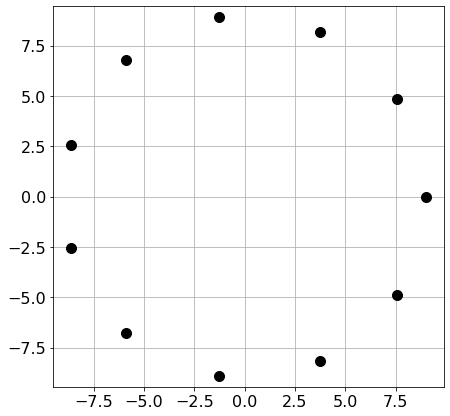

In [13]:
figs[1] = plt.figure(figsize=(7, 7))
figs[1].axa = figs[1].subplots(1, 1)
for wd in opt.wires:
    figs[1].axa.plot(wd['xw1'], wd['yw1'], marker='o', 
                     linestyle='None', color='k', markersize=10)
figs[1].axa.axis('equal')
figs[1].axa.grid()

_**Figure 1:** Array geometry in x, y plane_

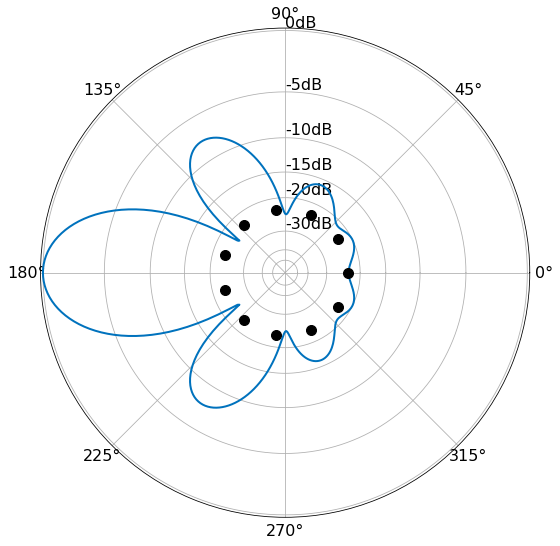

In [14]:
figs[2] = ptl.init_ARRL_polar_fig(plt, figsize=(9, 9))
ptl.add_ARRL_polar_plot(opt.azangs*np.pi/180,
                        10**(opt.gain/10), 
                        ax=figs[2].axa, color=ptl.plot_colors[1])

figs[2].axb = figs[2].add_axes(figs[2].axa.get_position(),
                       label='elplot',
                       frameon=False)
figs[2].axb.axis('equal')
xcoord = []
ycoord = []
for wd in opt.wires:
    xcoord.append(wd['xw1'])
    ycoord.append(wd['yw1'])

elbox = 35
figs[2].axb.set_xlim([-elbox, elbox])
figs[2].axb.set_ylim([-elbox, elbox])
sct = figs[2].axb.scatter(xcoord, ycoord)#, c=np.abs(multipleIopt[0]),cmap='magma',s=15)
#sct.set_clim([-2,0])
figs[2].axb.xaxis.set_visible(False)
figs[2].axb.yaxis.set_visible(False)
#figs[2].tight_layout()

_**Figure 2:** Array azimuth plot at 14.150MHz optimization frequency._

Text(0.5, 0, 'z (m)')

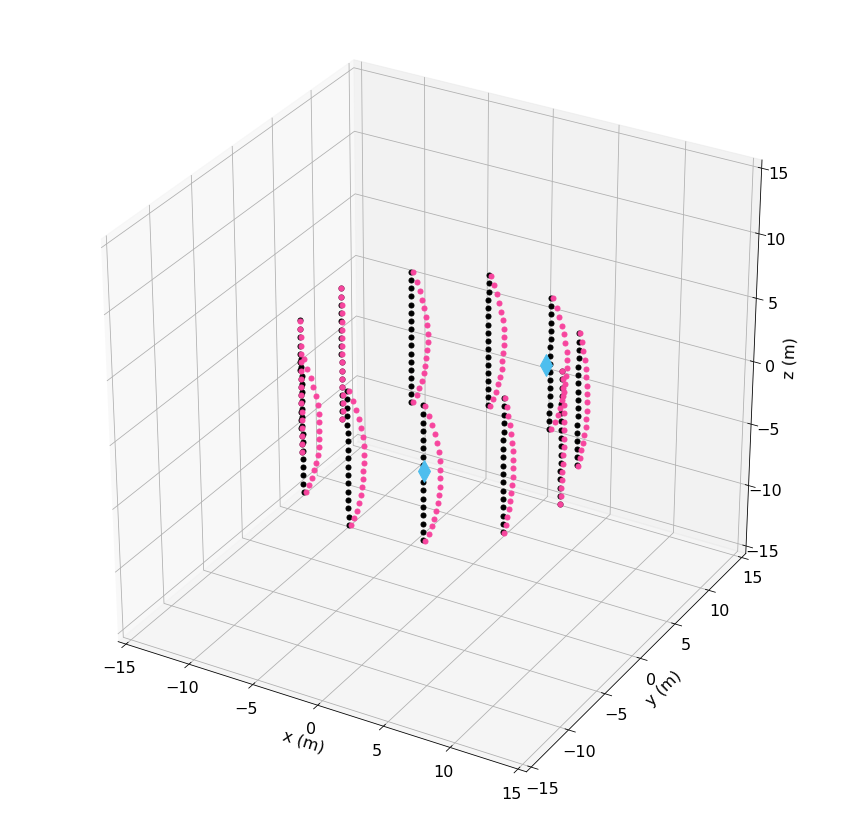

In [16]:
# --- Get structure currents --- 

opt.currdata = opt.context.get_structure_currents(0)
opt.currents = opt.currdata.get_current()

opt.currcoords = np.asarray([
                              22.10882284*opt.currdata.get_current_segment_center_x(),
                              22.10882284*opt.currdata.get_current_segment_center_y(),
                              22.10882284*opt.currdata.get_current_segment_center_z(),
                            ]).T

# --- Visualize current distribution ---
from mpl_toolkits.mplot3d import Axes3D # enables '3d' projection
figs[3] = plt.figure(figsize=(15,15))
figs[3].axa = figs[3].add_subplot(111, projection='3d')
ixsrc = 24

figs[3].axa.plot(opt.currcoords[0:ixsrc, 0],
                 opt.currcoords[0:ixsrc, 1],
                 opt.currcoords[0:ixsrc, 2],
                 color='k', linestyle='None', marker='.')

figs[3].axa.plot(opt.currcoords[ixsrc:, 0],
                 opt.currcoords[ixsrc:, 1],
                 opt.currcoords[ixsrc:, 2],
                 color='k', linestyle='None', marker='.')

curoptale = 0.1
figs[3].axa.plot(opt.currcoords[0:ixsrc, 0]+np.abs(opt.currents[0:ixsrc])/curoptale,
                 opt.currcoords[0:ixsrc, 1],
                 opt.currcoords[0:ixsrc, 2],
                 color='#f7459e', linestyle='None', marker='.')

figs[3].axa.plot(opt.currcoords[ixsrc:, 0]+np.abs(opt.currents[ixsrc:])/curoptale,
                 opt.currcoords[ixsrc:, 1],
                 opt.currcoords[ixsrc:, 2],
                 color='#f7459e', linestyle='None', marker='.')

figs[3].axa.plot([opt.wires[2]['xw1']],
                 [opt.wires[2]['yw1']],
                 [(opt.wires[2]['zw1']+opt.wires[2]['zw2'])/2],
                 marker='d', color=ptl.plot_colors[6], markersize=15)

figs[3].axa.plot([opt.wires[9]['xw1']],
                 [opt.wires[9]['yw1']],
                 [(opt.wires[9]['zw1']+opt.wires[9]['zw2'])/2],
                 marker='d', color=ptl.plot_colors[6], markersize=15)
lims = [-15,15]
for limsetter in [figs[3].axa.set_xlim, figs[3].axa.set_ylim, figs[3].axa.set_zlim]:
    limsetter(lims)
figs[3].axa.set_xlabel('x (m)')
figs[3].axa.set_ylabel('y (m)')
figs[3].axa.set_zlabel('z (m)')

_**Figure 3:** Element currents. Turquoise diamonds mark the feedpoints, which are fed in-phase with voltage sources._